# ANN + GMM Ensemble Model
## Chester 202018020317

# 1. Import Libraries

In [24]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import glob
from PIL import Image
import os
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter

# 2. Tools Preparation

## 2.1 ReLU Activation Function
This is a custom ReLU activation function that returns the maximum of 0 and the input value.
The reason for using this custom activation function is that the GMM model requires the input to be non-negative.
The formula is as follows:
$$
f(x)=\max (0, x)
$$

Where:
- $x$ is the input value
- $f(x)$ is the output value

In [25]:
def relu(x):
    """
    Custom ReLU activation function
    :param x: input value
    :return: output value
    """
    return tf.maximum(0.0, x)

## 2.2 Swish Activation Function
This is a custom swish activation function that returns the swish of the input value.
The formula is as follows:
$$
\[
f(x)=x \cdot \sigma(x)
\]
$$

Where:
- $x$ is the input value
- $f(x)$ is the output value
- $\sigma(x)$ is the sigmoid function

In [26]:
def swish(x):
    """
    Custom swish activation function
    :param x: input value
    :return: output value
    """
    return x * tf.sigmoid(x)

## 2.3 ELU Activation Function
This is a custom ELU activation function that returns the ELU of the input value.
The formula is as follows:
$$
\[
f(x)=\left\{\begin{array}{ll}
x & \text { if } x \geq 0 \\
\alpha\left(e^{x}-1\right) & \text { if } x<0
\end{array}\right.
\]
$$

Where:
- $x$ is the input value
- $f(x)$ is the output value

In [27]:
def elu(x, alpha=1.0):
    """
    Custom ELU activation function
    :param x: input value
    :param alpha: alpha value
    :return: output value
    """
    return tf.where(x >= 0.0, x, alpha * (tf.exp(x) - 1))

# 2.4 softmax Activation Function
This is a custom softmax activation function that returns the softmax of the input value.
The reason for using this custom activation function is that the GMM model requires the input to be non-negative.
The formula is as follows:
$$
\[
\sigma(\mathbf{z})_{j}=\frac{e^{z_{j}}}{\sum_{k=1}^{K} e^{z_{k}}}
\]
$$

Where:
- $z$ is the input value
- $j$ is the $j$-th element of the input value
- $K$ is the number of elements in the input value

In [28]:
def softmax(x):
    """
    Custom softmax activation function
    :param x: input value
    :return: output value
    """
    return tf.exp(x) / tf.reduce_sum(tf.exp(x))

# 2.5 Categorical Cross Entropy Loss Function
This is a custom loss function that calculates the loss of the model's predictions.
The formula is as follows:
$$
\[
L = -\sum_{c=1}^{M} y_{\text{true}, c} \cdot \log(y_{\text{pred}, c})
\]
$$

Where:
- $M$ is the number of classes
- $y_{\text{true}, c}$ is the true label of the $c$-th class
- $y_{\text{pred}, c}$ is the predicted label of the $c$-th class

In [29]:
def categorical_Entropy_Loss_Function(y_true, y_pred):
    """
    Custom loss function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: loss
    """
    return -tf.reduce_mean(y_true * tf.math.log(y_pred))

## 2.6 Custom Accuracy Function
This is a custom accuracy function that calculates the accuracy of the model's predictions.
The formula is as follows:
$$
\[
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(y_{\text{true}, i} = y_{\text{pred}, i})
\]

$$

Where:
- $N$ is the number of samples
- $y_{\text{true}, i}$ is the true label of the $i$-th sample
- $y_{\text{pred}, i}$ is the predicted label of the $i$-th sample
- $\mathbb{1}(x)$ is the indicator function, which is 1 if $x$ is true and 0 otherwise

In [30]:
def accuracy(y_true, y_pred):
    """
    Custom accuracy function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: accuracy
    """
    correct_predictions = tf.equal(tf.argmax(y_true, axis=1), tf.argmax(y_pred, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

# 3. Model Definition

## 3.1 ANN Model
This ANN model performs the classification task by learning the complex mapping relationship between the input car label images) and the categories of the output car labels. This ANN is designed to have multiple hidden layers with multiple neurons per hidden layer (these two parameters can be changed while building the model). It is responsible for extracting features from the input image and mapping these features to the output layer, where each neuron in the output layer represents the predicted probability of a category. Since the ANN knowledge integrates a part of the model, the output of the ANN (feature vector) is not used directly for classification decisions but as input to the GMM.

In [53]:
class ANNClassifier:
    def __init__(self, input_shape, num_classes, hidden_layers_sizes):
        """
        The constructor of the ANNClassifier class.
        :param input_shape: The shape of the input data
        :param num_classes: The number of classes
        :param hidden_layers_sizes: The sizes of the hidden layers
        """
        self.model = Sequential()
        self.model.add(Flatten(input_shape=input_shape))
        for i, layer_size in enumerate(hidden_layers_sizes):
            if i % 2 == 0:
                self.model.add(Dense(layer_size, activation=swish))
            else:
                self.model.add(Dense(layer_size, activation='elu'))
        self.model.add(Dense(num_classes, activation=softmax))

    def compile(self, optimizer):
        """
        Compiles the model.
        :param optimizer: The optimizer to use
        """
        self.model.compile(optimizer=optimizer, 
                           loss=categorical_Entropy_Loss_Function, 
                           metrics=[accuracy])

    def fit(self, X, y, epochs, batch_size):
        """
        Fits the model to the training data.
        :param X: the training data
        :param y: the training labels
        :param epochs: the number of epochs
        :param batch_size: the batch size
        :return: the history of the training process
        """
        self.history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size)
        return self.history

    def predict(self, X):
        """
        Predicts the labels of the data.
        :param X: the data used for prediction
        :return: the predicted labels
        """
        return self.model.predict(X)

## 3.2 GMM Model
In this integrated model, the role of the GMM is to cluster the output of the ANN. Specifically, it clusters the feature vectors of the ANN output into a number of classes, each representing a set of car labels with similar features.

In [54]:
class GMMClassifier:
    def __init__(self, n_components):
        """
        The constructor of the GMMClassifier class.
        :param n_components: The number of components
        """
        self.gmm = GaussianMixture(n_components=n_components)

    def fit(self, X):
        self.gmm.fit(X)

    def predict(self, X):
        return self.gmm.predict(X)

## 3.3 Ensemble Model
This is the integrated model that combines the ANN and GMM models. It takes the ANN and GMM models as input and uses the ANN model to extract features from the input data and the GMM model to cluster the extracted features.

In [55]:
class Ensemble:
    def __init__(self, supervised_model, unsupervised_model):
        """
        The constructor of the Ensemble class.
        :param supervised_model: the supervised model - ANN
        :param unsupervised_model: the unsupervised model - GMM
        """
        self.supervised_model = supervised_model
        self.unsupervised_model = unsupervised_model

    def fit(self, X, y, epochs, batch_size):
        """
        Fits the model to the training data.
        :param X: the training data
        :param y: the training labels
        :param epochs: the number of epochs in the ANN
        :param batch_size: the batch size in the ANN
        :return: the history of the training process
        """
        loss_history = self.supervised_model.fit(X, y, epochs, batch_size)
        features = self.supervised_model.predict(X)
        print(features.shape)
        self.unsupervised_model.fit(features)

        return loss_history

    def predict(self, X):
        """
        Predicts the labels of the data.
        :param X: the data used for prediction
        :return: the predicted labels
        """
        # Get ANN predictions to use as features for GMM
        predictions = self.supervised_model.predict(X)
        # Predict with GMM
        return self.unsupervised_model.predict(predictions)

# 4. Data Processing
## 4.1 Load & Preprocess Data 
This section contains the code for loading and preprocessing the data.

In [56]:
def load_images(image_paths, target_size):
    images = []
    labels = []
    for image_path in image_paths:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(target_size) 
        img_array = np.array(img)
        images.append(img_array)
        label = os.path.basename(os.path.dirname(image_path))
        labels.append(label)

    # Normalize pixel values
    images = np.array(images, dtype='float32') / 255.0
    # Convert labels to integer encoding
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    # Convert labels to one-hot encoding
    labels = tf.keras.utils.to_categorical(labels)
    return images, labels


# Load images
image_paths = glob.glob('Car_Logo_Dataset/**/*.png', recursive=True)
X, y = load_images(image_paths, target_size=(32, 32))

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
print(X[1])
print(X.shape)
print(y[1])
print(y.shape)

[[[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]]

 [[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]]

 [[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]]

 ...

 [[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]]

 [[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]


## 4.2 Data visualization

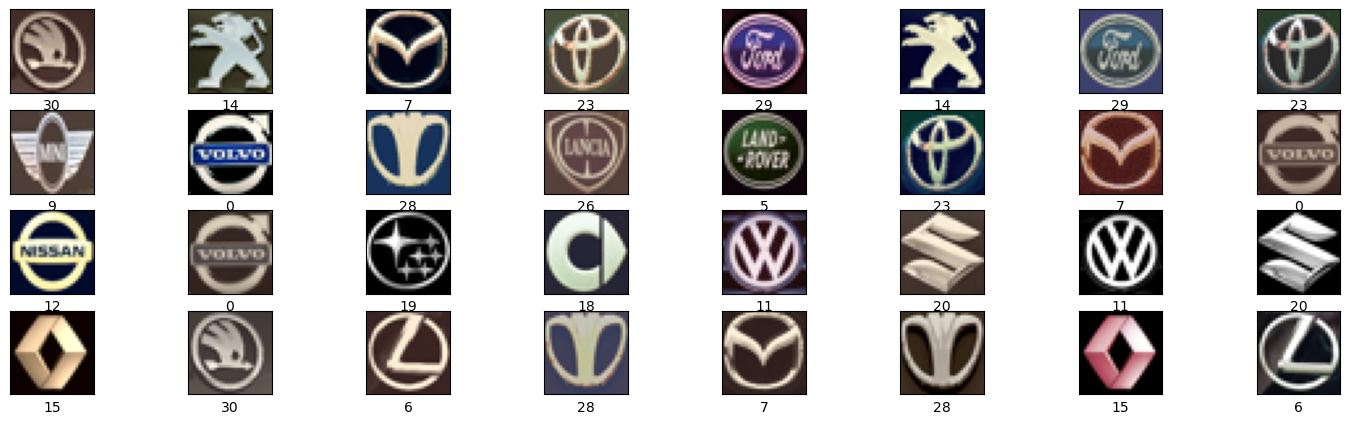

In [58]:
plt.figure(figsize=(18, 5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(np.argmax(y_train[i]))

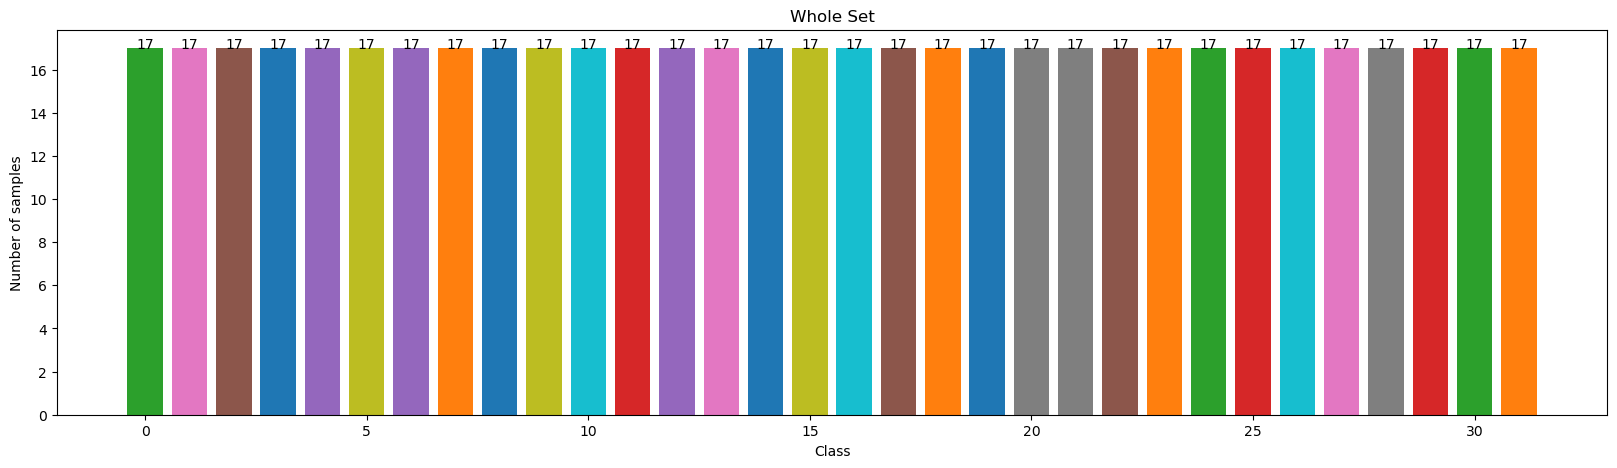

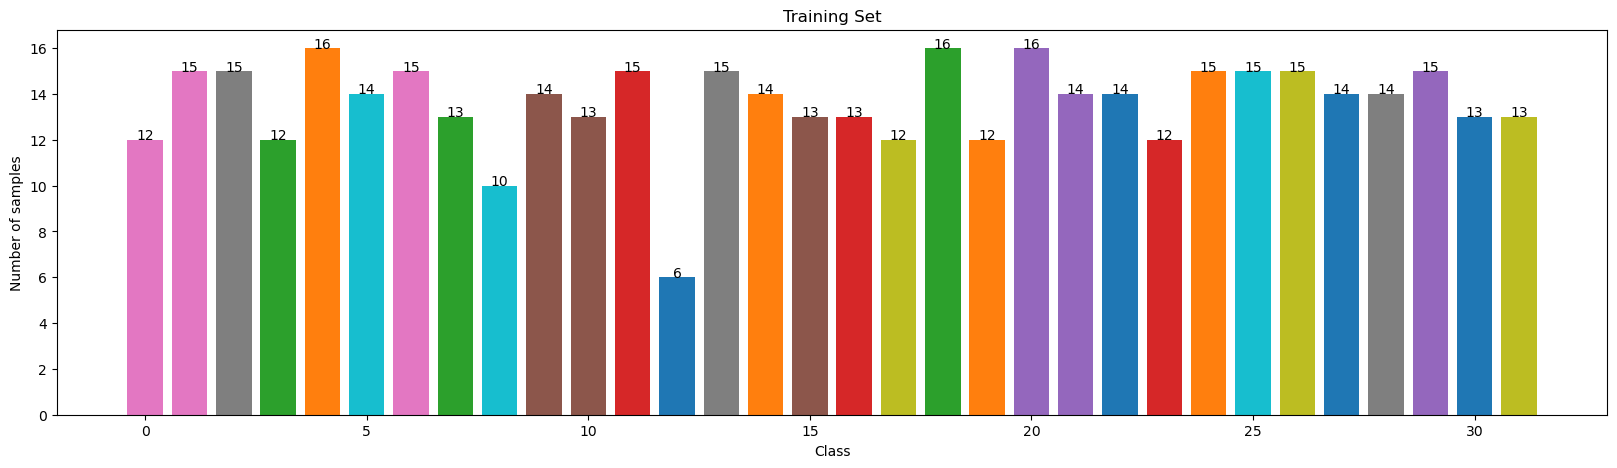

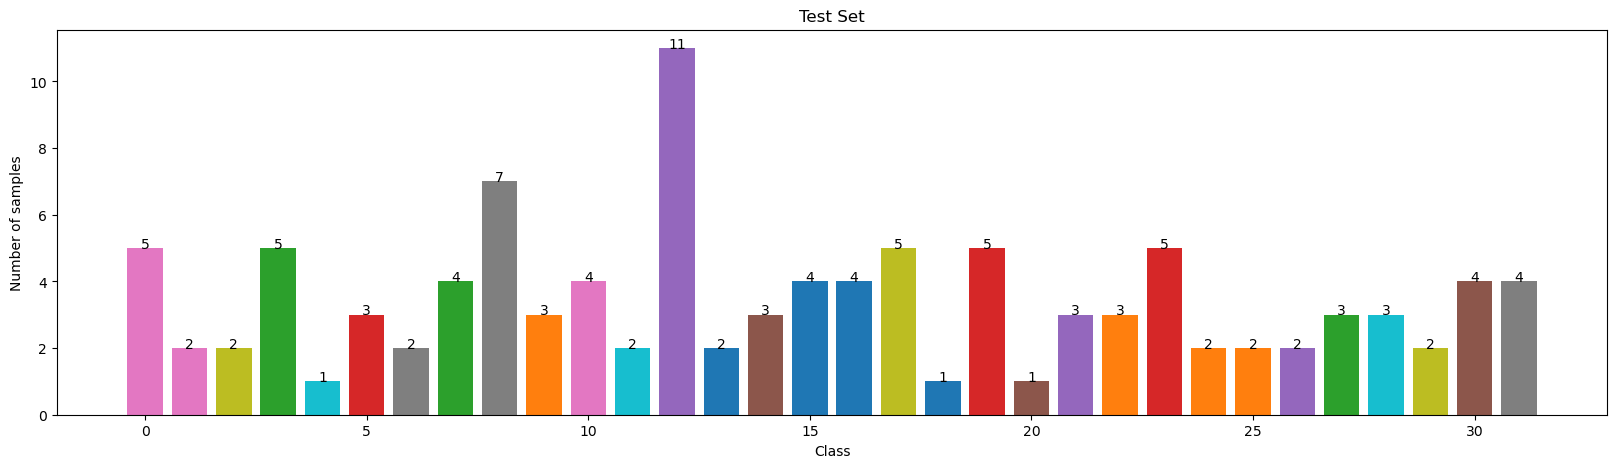

In [59]:
class DistributionPlotter:
    def __init__(self, y):
        self.y = y

    def plot(self, title=""):
        counter = Counter(self.y)
        numbers = list(counter.values())
        labels = list(counter.keys())
        colors = [f'C{i}' for i in range(len(numbers))]

        plt.figure(figsize=(20, 5))
        plt.bar(labels, numbers, color=colors)

        for i in range(len(numbers)):
            plt.text(labels[i], numbers[i], numbers[i], ha='center')

        plt.title(title)
        plt.xlabel('Class')
        plt.ylabel('Number of samples')
        plt.show()


DistributionPlotter(np.argmax(y, axis=1)).plot(title="Whole Set")
DistributionPlotter(np.argmax(y_train, axis=1)).plot(title="Training Set")
DistributionPlotter(np.argmax(y_test, axis=1)).plot(title="Test Set")

# 5. Model Building
## 5.1 Model Construction

In [60]:
ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                    hidden_layers_sizes=(128, 128, 128, 128))
ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
gmm = GMMClassifier(n_components=y_train.shape[1])
ensemble = Ensemble(ann, gmm)

## 5.2 Model Training

In [61]:
history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32)

y_pred = ensemble.predict(X_test)
y_test = np.argmax(y_test, axis=1)

Epoch 1/40


2023-12-11 09:23:44.611865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 32ms/step - loss: 0.1820 - accuracy: 0.5141
Epoch 2/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1340 - accuracy: 0.9628
Epoch 3/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1301 - accuracy: 0.9516
Epoch 4/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1253 - accuracy: 0.9844
Epoch 5/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1186 - accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1162 - accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1146 - accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 12ms/step - loss: 0.1139 - accuracy: 1.0000
Epoch 9/40
14/14 [==============================] - 0s 12ms/step - loss: 0.1128 - accuracy: 1.0000
Epoch 10/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1123 - accuracy: 1.0000
Epoch 11/40
14/14 [=

2023-12-11 09:23:52.540723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 18ms/step


# 6. Model Evaluation
## 6.1 Plot History

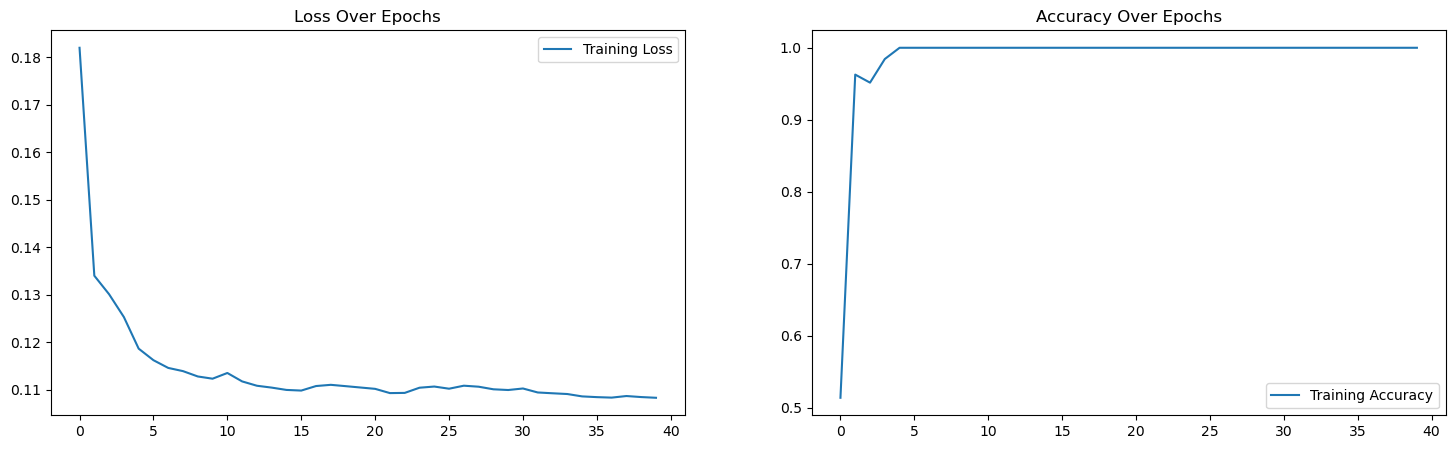

ANN Final cost: 0.1083054393529892
ANN Final accuracy: 1.0


In [62]:
def plot_history(history):
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.show()


plot_history(history)
print('ANN Final cost:', history.history['loss'][-1])
print('ANN Final accuracy:', history.history['accuracy'][-1])

## 6.2 Remap Labels
Due to the nature of the unsupervised model, the predicted labels may not be the same as the true labels. This function remaps the predicted labels to the true labels.

In [63]:
def remap_labels(true_labels, predicted_labels):
    unique_true_labels = np.unique(true_labels)
    mapped_labels = np.zeros_like(predicted_labels)
    
    for true_label in unique_true_labels:
        mask = (true_labels == true_label)
        predicted_labels_for_true_label = predicted_labels[mask]        
        unique_predicted, counts = np.unique(predicted_labels_for_true_label, return_counts=True)
        most_common = unique_predicted[np.argmax(counts)]
        mapped_labels[predicted_labels == most_common] = true_label
    
    return mapped_labels

mapped_predictions = remap_labels(y_test, y_pred)

In [64]:
print("True labels:")
print(y_test)
print("Predicted labels:")
print(y_pred)
print("Remapped predicted labels:")
print(mapped_predictions)

True labels:
[13 22  7 23 23 12 20 12 12  0  8  2  4 12 23  2 15 25  3 19 12 21 15  0
 30  8  1  3  8  3 12  6 12 17 19 11 15 19 21 16  9 27  5 26 16 14  9 10
  7  9 31 29 12 12  3 13  8 16 14 23 30  6 10 30 19 23 17 28  0 18 11 12
 28 10 29 12 19 25 28 17 27  3 31 10  5  8  8 22 31  7  0 17  1 15 22 21
  7  0 31 30  5  8 14 24 16 27 24 17 26]
Predicted labels:
[19 18  6  5  5 31  4 31 31 26 28 27 22 31  5 27 16 14  0 23 31  8 16 26
  7 28 20  0 28  0 31 21 31 25 23  1 16 23  8 17 13 10 11  3 17 15 13 12
  6 13  2 24 31 31  0 19 28 17 15  5  7 21 12  7 23  5 25 29 26  9  1 31
 29 12 24 31 23 14 29 25 10  0  2 12 11 28 28 18  2  6 26 25 20 16 18  8
  6 26  2  7 11 28 15 30 17 10 30 25  3]
Remapped predicted labels:
[13 22  7 23 23 12 20 12 12  0  8  2  4 12 23  2 15 25  3 19 12 21 15  0
 30  8  1  3  8  3 12  6 12 17 19 11 15 19 21 16  9 27  5 26 16 14  9 10
  7  9 31 29 12 12  3 13  8 16 14 23 30  6 10 30 19 23 17 28  0 18 11 12
 28 10 29 12 19 25 28 17 27  3 31 10  5  8  8 22 31  7  0

## 6.3 Confusion Matrix

Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

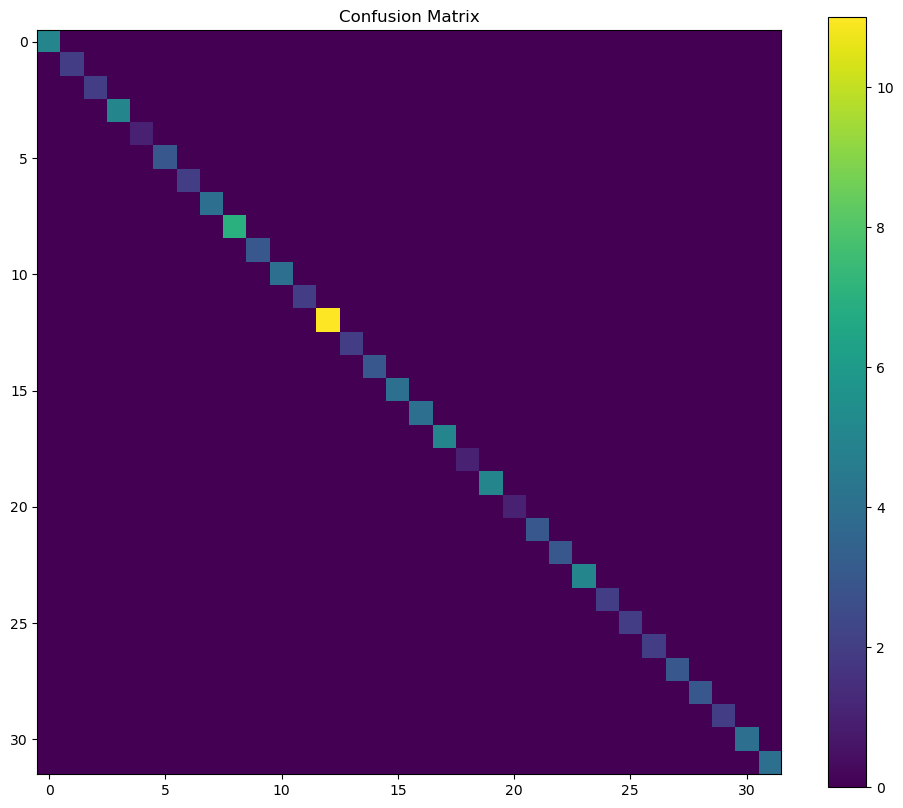

In [65]:
def confusion_matrix(y_true, y_pred):
    """
    Compute and print the confusion matrix, classification report, and estimate ROC AUC.
    
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the confusion matrix
    """
    num_classes = len(np.unique(y_true))
    result = np.zeros((num_classes, num_classes))
    roc_auc_scores = np.zeros(num_classes)

    for i in range(len(y_true)):
        result[y_true[i]][y_pred[i]] += 1

    true_positive = np.diag(result)
    false_positive = np.sum(result, axis=0) - true_positive
    false_negative = np.sum(result, axis=1) - true_positive
    true_negative = np.sum(result) - (true_positive + false_positive + false_negative)

    epsilon = 1e-7
    recall = true_positive / (true_positive + false_negative + epsilon)
    precision = true_positive / (true_positive + false_positive + epsilon)
    f1_score = 2 * precision * recall / (precision + recall + epsilon)
    support = np.sum(result, axis=1)

    print("Model Report")
    print("=" * 80)
    print("{:>10} {:>10} {:>10} {:>10} {:>10} {:>10}".format('Class', 'Precision', 'Recall', 'F1-Score', 'ROC AUC',
                                                             'Support'))
    for i in range(num_classes):
        TPR = recall[i]
        FPR = false_positive[i] / (false_positive[i] + true_negative[i] + epsilon)
        roc_auc = (1 + TPR - FPR) / 2
        roc_auc_scores[i] = roc_auc

        print("{:>10d} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.2f} {:>10d}".format(i + 1, precision[i], recall[i],
                                                                               f1_score[i], roc_auc, int(support[i])))

    print("=" * 80)
    print("Avg Recall: {:.2f}".format(np.mean(recall)))
    print("Avg Precision: {:.2f}".format(np.mean(precision)))
    print("Avg F1-Score: {:.2f}".format(np.mean(f1_score)))
    print("Avg ROC AUC: {:.2f}".format(np.mean(roc_auc_scores)))

    return result


conf_matrix = confusion_matrix(y_test, mapped_predictions)
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, cmap='viridis')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

# 6.4 Accuracy
This is a custom accuracy function that calculates the accuracy of the model's predictions.
The formula is as follows:
$$
\[
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(y_{\text{true}, i} = y_{\text{pred}, i})
\]

$$

Where:
- $N$ is the number of samples
- $y_{\text{true}, i}$ is the true label of the $i$-th sample
- $y_{\text{pred}, i}$ is the predicted label of the $i$-th sample

In [44]:
def custom_accuracy(y_true, y_pred):
    """
    Custom accuracy function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: accuracy
    """
    correct_predictions = tf.equal(y_true, y_pred)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32)) * 100


print(f"Accuracy: {custom_accuracy(y_test, mapped_predictions).numpy():.3f}%")

Accuracy: 93.578%


# 6.5 Visualization

4/4 [==============================] - 0s 4ms/step


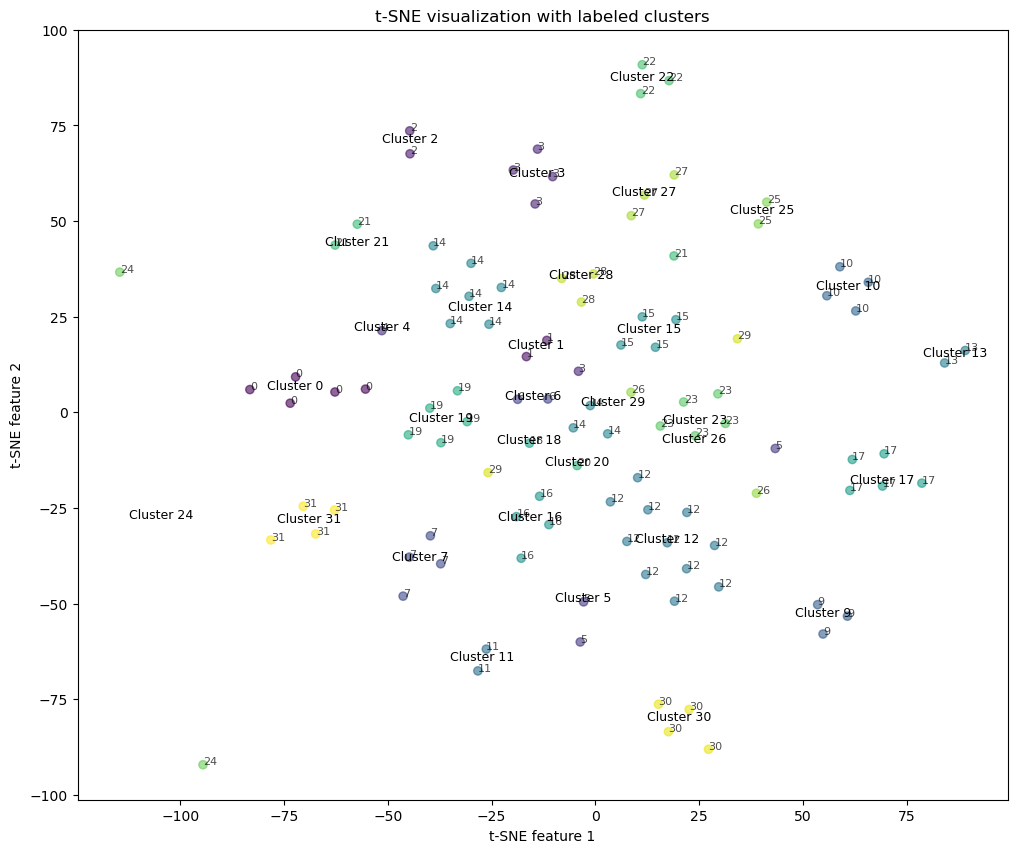

In [45]:
def visualize_clusters_with_labels(X, y, model):
    features = model.predict(X)

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    # tsne = PCA(n_components=10, random_state=42)
    X_reduced = tsne.fit_transform(features)

    plt.figure(figsize=(12, 10))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.6)

    unique_labels = np.unique(y)
    for i, label in enumerate(unique_labels):
        xtext, ytext = np.median(X_reduced[y == label, :], axis=0)
        txt = f'Cluster {label}'
        plt.annotate(txt, (xtext, ytext), fontsize=9, ha='center')

    for i, txt in enumerate(y):
        plt.annotate(txt, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8, alpha=0.7)

    plt.title('t-SNE visualization with labeled clusters')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()


visualize_clusters_with_labels(X_test, mapped_predictions, ann)

## 6.6 Set different hidden layers of ANN

Epoch 1/40


2023-12-11 09:18:17.848505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 20ms/step - loss: 0.1767 - accuracy: 0.5922
Epoch 2/40
14/14 [==============================] - 0s 11ms/step - loss: 0.1431 - accuracy: 0.8831
Epoch 3/40
14/14 [==============================] - 0s 10ms/step - loss: 0.1292 - accuracy: 0.9688
Epoch 4/40
14/14 [==============================] - 0s 11ms/step - loss: 0.1242 - accuracy: 0.9955
Epoch 5/40
14/14 [==============================] - 0s 11ms/step - loss: 0.1225 - accuracy: 0.9978
Epoch 6/40
14/14 [==============================] - 0s 21ms/step - loss: 0.1206 - accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 10ms/step - loss: 0.1183 - accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 12ms/step - loss: 0.1159 - accuracy: 1.0000
Epoch 9/40
14/14 [==============================] - 0s 12ms/step - loss: 0.1164 - accuracy: 1.0000
Epoch 10/40
14/14 [==============================] - 0s 10ms/step - loss: 0.1164 - accuracy: 1.0000
Epoch 11/40
14/14 [=

2023-12-11 09:18:24.562058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 10ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.49          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       0.50       0.67       0.75          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-11 09:18:25.785294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 23ms/step - loss: 0.1841 - accuracy: 0.5067
Epoch 2/40
14/14 [==============================] - 0s 12ms/step - loss: 0.1441 - accuracy: 0.8869
Epoch 3/40
14/14 [==============================] - 0s 11ms/step - loss: 0.1315 - accuracy: 0.9777
Epoch 4/40
14/14 [==============================] - 0s 11ms/step - loss: 0.1301 - accuracy: 0.9643
Epoch 5/40
14/14 [==============================] - 0s 10ms/step - loss: 0.1203 - accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1170 - accuracy: 0.9978
Epoch 7/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1170 - accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1148 - accuracy: 1.0000
Epoch 9/40
14/14 [==============================] - 0s 11ms/step - loss: 0.1143 - accuracy: 1.0000
Epoch 10/40
14/14 [==============================] - 0s 11ms/step - loss: 0.1152 - accuracy: 1.0000
Epoch 11/40
14/14 [=

2023-12-11 09:18:32.844518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 11ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       0.00       0.00       0.00       0.50          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-11 09:18:34.071280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 23ms/step - loss: 0.1891 - accuracy: 0.4754
Epoch 2/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1343 - accuracy: 0.9389
Epoch 3/40
14/14 [==============================] - 0s 25ms/step - loss: 0.1366 - accuracy: 0.9286
Epoch 4/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1284 - accuracy: 0.9799
Epoch 5/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1209 - accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1185 - accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1172 - accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1152 - accuracy: 1.0000
Epoch 9/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1141 - accuracy: 1.0000
Epoch 10/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1121 - accuracy: 1.0000
Epoch 11/40
14/14 [=

2023-12-11 09:18:42.828802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 16ms/step
(435, 32)
4/4 [==============================] - 0s 16ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-11 09:18:43.910891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 27ms/step - loss: 0.1997 - accuracy: 0.3272
Epoch 2/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1417 - accuracy: 0.8913
Epoch 3/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1323 - accuracy: 0.9494
Epoch 4/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1248 - accuracy: 0.9844
Epoch 5/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1216 - accuracy: 0.9888
Epoch 6/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1182 - accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1161 - accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1148 - accuracy: 1.0000
Epoch 9/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1143 - accuracy: 1.0000
Epoch 10/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1136 - accuracy: 1.0000
Epoch 11/40
14/14 [=

2023-12-11 09:18:52.661235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 24ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       0.00       0.00       0.00       0.50         11
        14       1.00       1.00       1.00       1.00         

2023-12-11 09:18:54.606619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 30ms/step - loss: 0.1934 - accuracy: 0.3226
Epoch 2/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1520 - accuracy: 0.8103
Epoch 3/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1326 - accuracy: 0.9538
Epoch 4/40
14/14 [==============================] - 0s 12ms/step - loss: 0.1260 - accuracy: 0.9799
Epoch 5/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1217 - accuracy: 0.9978
Epoch 6/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1190 - accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1187 - accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1167 - accuracy: 1.0000
Epoch 9/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1160 - accuracy: 1.0000
Epoch 10/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1149 - accuracy: 1.0000
Epoch 11/40
14/14 [=

2023-12-11 09:19:03.018878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 18ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14 

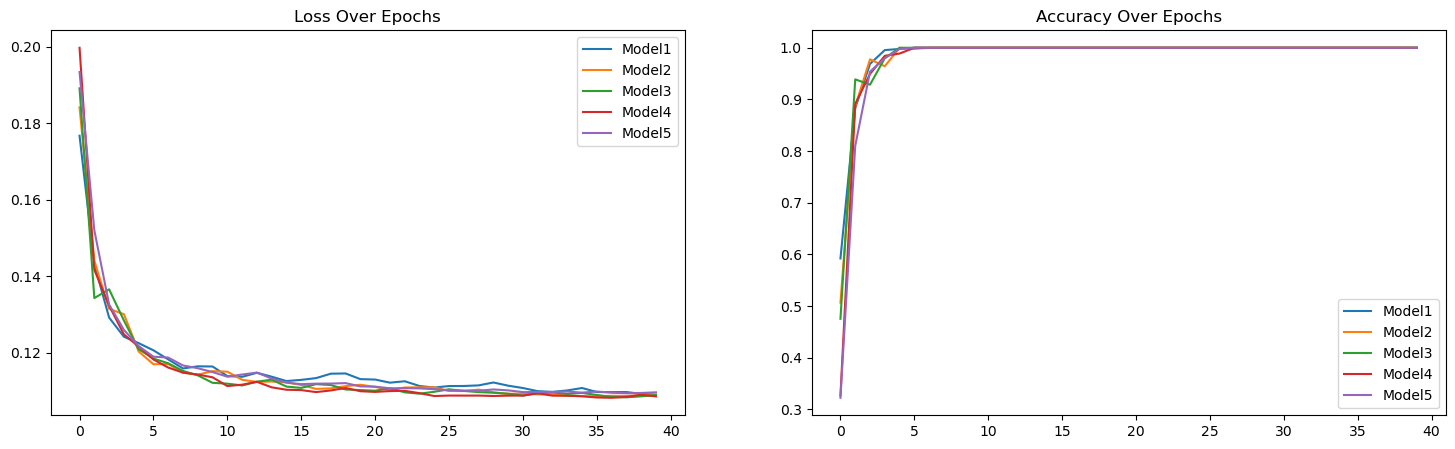

Final loss of Model1: 0.1090
Final loss of Model2: 0.1089
Final loss of Model3: 0.1089
Final loss of Model4: 0.1086
Final loss of Model5: 0.1096
Final accuracy of Model1: 93.578%
Final accuracy of Model2: 93.578%
Final accuracy of Model3: 100.000%
Final accuracy of Model4: 89.908%
Final accuracy of Model5: 98.165%


In [46]:
def test_model(hidden_layers_sizes):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=hidden_layers_sizes)
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32)
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(y_test, y_pred)
    confusion_matrix(y_test, mapped_predictions)
    accuracy = custom_accuracy(y_test, mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model((128, 128))
Model2_history, Model2_accuracy = test_model((128, 128, 128))
Model3_history, Model3_accuracy = test_model((128, 128, 128, 128))
Model4_history, Model4_accuracy = test_model((128, 128, 128, 128, 128))
Model5_history, Model5_accuracy = test_model((128, 64, 32, 32))

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.plot(Model4_history.history['loss'], label='Model4')
plt.plot(Model5_history.history['loss'], label='Model5')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.plot(Model4_history.history['accuracy'], label='Model4')
plt.plot(Model5_history.history['accuracy'], label='Model5')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()
print("Final loss of Model1:", f"{Model1_history.history['loss'][-1]:.4f}")
print("Final loss of Model2:", f"{Model2_history.history['loss'][-1]:.4f}")
print("Final loss of Model3:", f"{Model3_history.history['loss'][-1]:.4f}")
print("Final loss of Model4:", f"{Model4_history.history['loss'][-1]:.4f}")
print("Final loss of Model5:", f"{Model5_history.history['loss'][-1]:.4f}")
print("Final accuracy of Model1:", f"{Model1_accuracy:.3f}%")
print("Final accuracy of Model2:", f"{Model2_accuracy:.3f}%")
print("Final accuracy of Model3:", f"{Model3_accuracy:.3f}%")
print("Final accuracy of Model4:", f"{Model4_accuracy:.3f}%")
print("Final accuracy of Model5:", f"{Model5_accuracy:.3f}%")

## 6.7 Set different learning rates of ANN

Epoch 1/40


2023-12-11 09:19:04.662722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 24ms/step - loss: 0.1844 - accuracy: 0.4523
Epoch 2/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1367 - accuracy: 0.9211
Epoch 3/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1321 - accuracy: 0.9732
Epoch 4/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1263 - accuracy: 0.9710
Epoch 5/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1221 - accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1190 - accuracy: 0.9978
Epoch 7/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1152 - accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1153 - accuracy: 1.0000
Epoch 9/40
14/14 [==============================] - 0s 12ms/step - loss: 0.1142 - accuracy: 0.9978
Epoch 10/40
14/14 [==============================] - 0s 24ms/step - loss: 0.1132 - accuracy: 1.0000
Epoch 11/40
14/14 [=

2023-12-11 09:19:13.157626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 15ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-11 09:19:14.408435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 48ms/step - loss: 0.1885 - accuracy: 0.3889
Epoch 2/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1664 - accuracy: 0.6433
Epoch 3/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1437 - accuracy: 0.8586
Epoch 4/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1291 - accuracy: 0.9420
Epoch 5/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1265 - accuracy: 0.9799
Epoch 6/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1253 - accuracy: 0.9866
Epoch 7/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1180 - accuracy: 0.9955
Epoch 8/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1190 - accuracy: 0.9866
Epoch 9/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1138 - accuracy: 0.9978
Epoch 10/40
14/14 [==============================] - 0s 12ms/step - loss: 0.1153 - accuracy: 1.0000
Epoch 11/40
14/14 [=

2023-12-11 09:19:22.919125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 35ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-11 09:19:24.134225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 30ms/step - loss: 0.3418 - accuracy: 0.0424
Epoch 2/40
14/14 [==============================] - 0s 16ms/step - loss: 0.2056 - accuracy: 0.1303
Epoch 3/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1784 - accuracy: 0.4223
Epoch 4/40
14/14 [==============================] - 0s 23ms/step - loss: 0.1505 - accuracy: 0.7036
Epoch 5/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1417 - accuracy: 0.7856
Epoch 6/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1293 - accuracy: 0.9241
Epoch 7/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1315 - accuracy: 0.9329
Epoch 8/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1313 - accuracy: 0.9174
Epoch 9/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1257 - accuracy: 0.9509
Epoch 10/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1237 - accuracy: 0.9806
Epoch 11/40
14/14 [=

2023-12-11 09:19:32.938973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 21ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       0.00       0.00       0.00       0.50         11
        14 

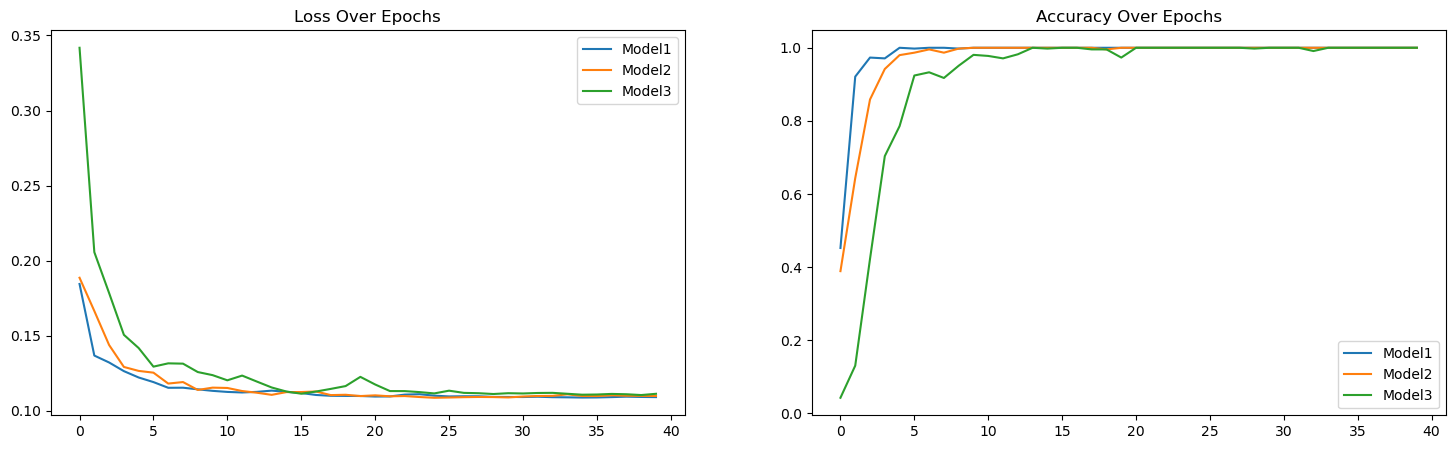

Final loss of Model1: 0.1090
Final loss of Model2: 0.1098
Final loss of Model3: 0.1112
Final accuracy of Model1: 100.000%
Final accuracy of Model2: 100.000%
Final accuracy of Model3: 87.156%


In [47]:
def test_model(learning_rate):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128))
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32)
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(y_test, y_pred)
    confusion_matrix(y_test, mapped_predictions)
    accuracy = custom_accuracy(y_test, mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(0.001)
Model2_history, Model2_accuracy = test_model(0.003)
Model3_history, Model3_accuracy = test_model(0.009)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()
print("Final loss of Model1:", f"{Model1_history.history['loss'][-1]:.4f}")
print("Final loss of Model2:", f"{Model2_history.history['loss'][-1]:.4f}")
print("Final loss of Model3:", f"{Model3_history.history['loss'][-1]:.4f}")
print("Final accuracy of Model1:", f"{Model1_accuracy:.3f}%")
print("Final accuracy of Model2:", f"{Model2_accuracy:.3f}%")
print("Final accuracy of Model3:", f"{Model3_accuracy:.3f}%")

## 6.8 Set different batch sizes of ANN

Epoch 1/40


2023-12-11 09:19:34.979741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 2s 24ms/step - loss: 0.1714 - accuracy: 0.5060
Epoch 2/40
28/28 [==============================] - 0s 14ms/step - loss: 0.1190 - accuracy: 0.9621
Epoch 3/40
28/28 [==============================] - 0s 14ms/step - loss: 0.1074 - accuracy: 0.9844
Epoch 4/40
28/28 [==============================] - 0s 14ms/step - loss: 0.0998 - accuracy: 1.0000
Epoch 5/40
28/28 [==============================] - 0s 16ms/step - loss: 0.0976 - accuracy: 1.0000
Epoch 6/40
28/28 [==============================] - 0s 14ms/step - loss: 0.0969 - accuracy: 1.0000
Epoch 7/40
28/28 [==============================] - 0s 14ms/step - loss: 0.0935 - accuracy: 1.0000
Epoch 8/40
28/28 [==============================] - 0s 13ms/step - loss: 0.0937 - accuracy: 1.0000
Epoch 9/40
28/28 [==============================] - 0s 18ms/step - loss: 0.0939 - accuracy: 1.0000
Epoch 10/40
28/28 [==============================] - 0s 14ms/step - loss: 0.0919 - accuracy: 1.0000
Epoch 11/40
28/28 [=

2023-12-11 09:19:51.525201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 16ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-11 09:19:52.762789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 33ms/step - loss: 0.2049 - accuracy: 0.2430
Epoch 2/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1667 - accuracy: 0.8652
Epoch 3/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1363 - accuracy: 0.9821
Epoch 4/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1237 - accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1207 - accuracy: 0.9918
Epoch 6/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1178 - accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1165 - accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1158 - accuracy: 1.0000
Epoch 9/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1147 - accuracy: 1.0000
Epoch 10/40
14/14 [==============================] - 0s 23ms/step - loss: 0.1138 - accuracy: 1.0000
Epoch 11/40
14/14 [=

2023-12-11 09:20:01.617130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 19ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-11 09:20:03.252372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 53ms/step - loss: 0.2300 - accuracy: 0.2474
Epoch 2/40
7/7 [==============================] - 0s 21ms/step - loss: 0.2072 - accuracy: 0.7879
Epoch 3/40
7/7 [==============================] - 0s 18ms/step - loss: 0.1819 - accuracy: 0.8861
Epoch 4/40
7/7 [==============================] - 0s 16ms/step - loss: 0.1613 - accuracy: 0.9643
Epoch 5/40
7/7 [==============================] - 0s 17ms/step - loss: 0.1485 - accuracy: 0.9754
Epoch 6/40
7/7 [==============================] - 0s 15ms/step - loss: 0.1422 - accuracy: 1.0000
Epoch 7/40
7/7 [==============================] - 0s 18ms/step - loss: 0.1404 - accuracy: 1.0000
Epoch 8/40
7/7 [==============================] - 0s 19ms/step - loss: 0.1388 - accuracy: 1.0000
Epoch 9/40
7/7 [==============================] - 0s 16ms/step - loss: 0.1378 - accuracy: 1.0000
Epoch 10/40
7/7 [==============================] - 0s 15ms/step - loss: 0.1368 - accuracy: 1.0000
Epoch 11/40
7/7 [=======================

2023-12-11 09:20:08.336448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 19ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14 

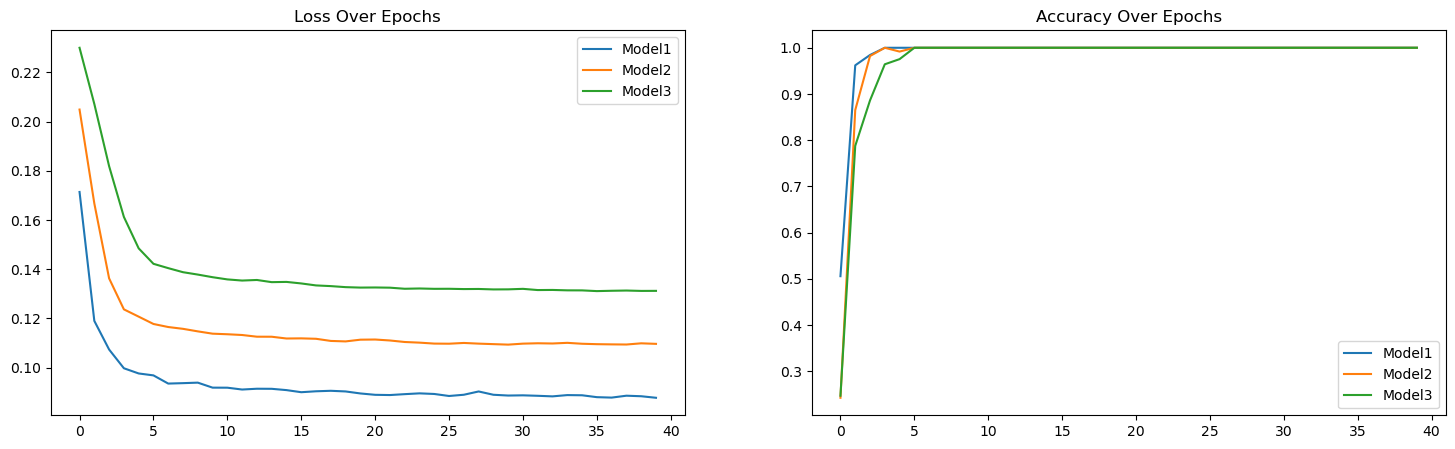

Final loss of Model1: 0.0878
Final loss of Model2: 0.1097
Final loss of Model3: 0.1312
Final accuracy of Model1: 100.000%
Final accuracy of Model2: 100.000%
Final accuracy of Model3: 100.000%


In [48]:
def test_model(batch_size):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128))
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=batch_size)
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(y_test, y_pred)
    confusion_matrix(y_test, mapped_predictions)
    accuracy = custom_accuracy(y_test, mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(16)
Model2_history, Model2_accuracy = test_model(32)
Model3_history, Model3_accuracy = test_model(64)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()
print("Final loss of Model1:", f"{Model1_history.history['loss'][-1]:.4f}")
print("Final loss of Model2:", f"{Model2_history.history['loss'][-1]:.4f}")
print("Final loss of Model3:", f"{Model3_history.history['loss'][-1]:.4f}")
print("Final accuracy of Model1:", f"{Model1_accuracy:.3f}%")
print("Final accuracy of Model2:", f"{Model2_accuracy:.3f}%")
print("Final accuracy of Model3:", f"{Model3_accuracy:.3f}%")

## 6.9 Set different optimizers of ANN

Epoch 1/40


2023-12-11 09:20:10.477684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 31ms/step - loss: 0.2078 - accuracy: 0.1997
Epoch 2/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1715 - accuracy: 0.8065
Epoch 3/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1382 - accuracy: 0.9621
Epoch 4/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.9933
Epoch 5/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1215 - accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1197 - accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1193 - accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1173 - accuracy: 1.0000
Epoch 9/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1169 - accuracy: 1.0000
Epoch 10/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1151 - accuracy: 1.0000
Epoch 11/40
14/14 [=

2023-12-11 09:20:19.328085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 21ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.71       1.00       0.83       0.99          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       0.00       0.00       0.00       0.50          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-11 09:20:23.231474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 33ms/step - loss: 0.2177 - accuracy: 0.0522
Epoch 2/40
14/14 [==============================] - 0s 13ms/step - loss: 0.2177 - accuracy: 0.0506
Epoch 3/40
14/14 [==============================] - 0s 13ms/step - loss: 0.2177 - accuracy: 0.0522
Epoch 4/40
14/14 [==============================] - 0s 14ms/step - loss: 0.2177 - accuracy: 0.0522
Epoch 5/40
14/14 [==============================] - 0s 13ms/step - loss: 0.2177 - accuracy: 0.0491
Epoch 6/40
14/14 [==============================] - 0s 12ms/step - loss: 0.2177 - accuracy: 0.0491
Epoch 7/40
14/14 [==============================] - 0s 13ms/step - loss: 0.2177 - accuracy: 0.0522
Epoch 8/40
14/14 [==============================] - 0s 12ms/step - loss: 0.2177 - accuracy: 0.0506
Epoch 9/40
14/14 [==============================] - 0s 13ms/step - loss: 0.2176 - accuracy: 0.0506
Epoch 10/40
14/14 [==============================] - 0s 20ms/step - loss: 0.2176 - accuracy: 0.0491
Epoch 11/40
14/14 [=

2023-12-11 09:20:30.826124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 15ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       0.00       0.00       0.00       0.50          2
         3       0.00       0.00       0.00       0.50          2
         4       0.00       0.00       0.00       0.50          5
         5       0.00       0.00       0.00       0.50          1
         6       0.00       0.00       0.00       0.50          3
         7       0.00       0.00       0.00       0.50          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       0.00       0.00       0.00       0.50          4
        12       0.00       0.00       0.00       0.50          2
        13       0.00       0.00       0.00       0.50         11
        14       0.00       0.00       0.00       0.50         

2023-12-11 09:20:32.346312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 39ms/step - loss: 0.1935 - accuracy: 0.4335
Epoch 2/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1522 - accuracy: 0.8735
Epoch 3/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1322 - accuracy: 0.9739
Epoch 4/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1277 - accuracy: 0.9732
Epoch 5/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1256 - accuracy: 0.9911
Epoch 6/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1231 - accuracy: 0.9933
Epoch 7/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1199 - accuracy: 0.9978
Epoch 8/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1199 - accuracy: 0.9955
Epoch 9/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1188 - accuracy: 0.9978
Epoch 10/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1172 - accuracy: 0.9978
Epoch 11/40
14/14 [=

2023-12-11 09:20:42.512217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 13ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.62       1.00       0.77       0.99          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       0.50       0.67       0.75          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       0.50       0.67       0.75          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       0.00       0.00       0.00       0.50          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-11 09:20:43.374852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 30ms/step - loss: 0.2155 - accuracy: 0.0089
Epoch 2/40
14/14 [==============================] - 0s 14ms/step - loss: 0.2154 - accuracy: 0.0089
Epoch 3/40
14/14 [==============================] - 0s 13ms/step - loss: 0.2154 - accuracy: 0.0105
Epoch 4/40
14/14 [==============================] - 0s 14ms/step - loss: 0.2154 - accuracy: 0.0089
Epoch 5/40
14/14 [==============================] - 0s 13ms/step - loss: 0.2154 - accuracy: 0.0089
Epoch 6/40
14/14 [==============================] - 0s 12ms/step - loss: 0.2154 - accuracy: 0.0089
Epoch 7/40
14/14 [==============================] - 0s 14ms/step - loss: 0.2154 - accuracy: 0.0089
Epoch 8/40
14/14 [==============================] - 0s 13ms/step - loss: 0.2153 - accuracy: 0.0089
Epoch 9/40
14/14 [==============================] - 0s 12ms/step - loss: 0.2153 - accuracy: 0.0089
Epoch 10/40
14/14 [==============================] - 0s 13ms/step - loss: 0.2153 - accuracy: 0.0089
Epoch 11/40
14/14 [=

2023-12-11 09:20:50.921160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 14ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       0.00       0.00       0.00       0.50          2
         3       0.00       0.00       0.00       0.50          2
         4       0.00       0.00       0.00       0.50          5
         5       0.00       0.00       0.00       0.50          1
         6       0.00       0.00       0.00       0.50          3
         7       0.00       0.00       0.00       0.50          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       0.00       0.00       0.00       0.50          4
        12       0.00       0.00       0.00       0.50          2
        13       0.00       0.00       0.00       0.50         11
        14 

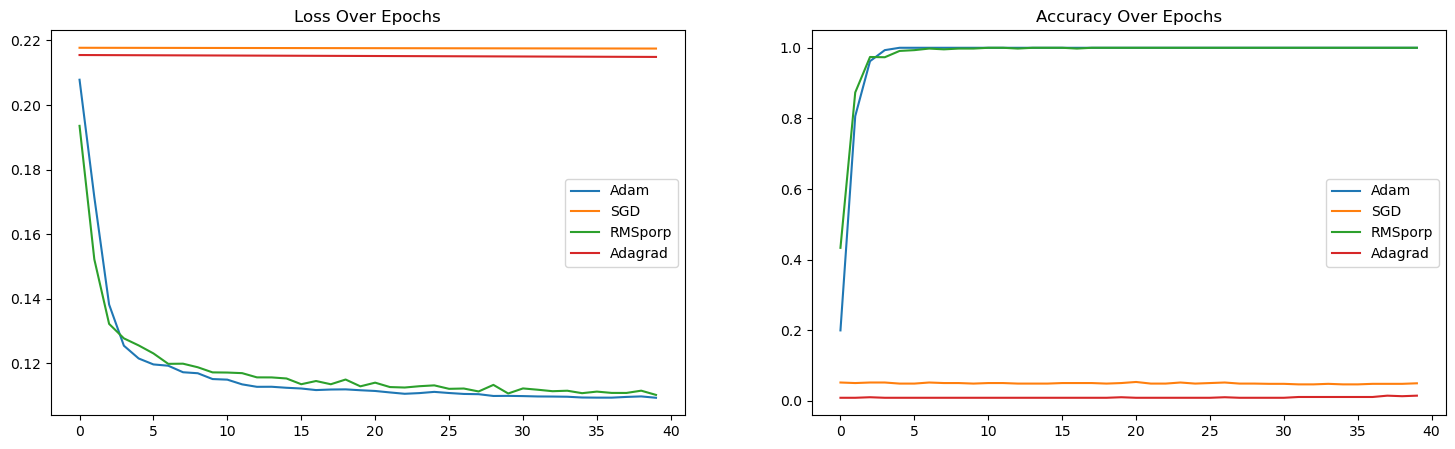

Final loss of Adam Model: 0.1094
Final loss of SGD Model: 0.2175
Final loss of RMSporp Model: 0.1102
Final loss of Adagrad Model: 0.2149
Final accuracy of Adam Model: 94.495%
Final accuracy of SGD Model: 3.670%
Final accuracy of RMSporp Model: 90.826%
Final accuracy of Adagrad Model: 3.670%


In [49]:
def test_model(optimizer):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128))
    ann.compile(optimizer=optimizer)
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32)
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(y_test, y_pred)
    confusion_matrix(y_test, mapped_predictions)
    accuracy = custom_accuracy(y_test, mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(tf.keras.optimizers.Adam(learning_rate=0.0003))
Model2_history, Model2_accuracy = test_model(tf.keras.optimizers.SGD(learning_rate=0.0003))
Model3_history, Model3_accuracy = test_model(tf.keras.optimizers.RMSprop(learning_rate=0.0003))
Model4_history, Model4_accuracy = test_model(tf.keras.optimizers.Adagrad(learning_rate=0.0003))

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Adam')
plt.plot(Model2_history.history['loss'], label='SGD')
plt.plot(Model3_history.history['loss'], label='RMSporp')
plt.plot(Model4_history.history['loss'], label='Adagrad')

plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Adam')
plt.plot(Model2_history.history['accuracy'], label='SGD')
plt.plot(Model3_history.history['accuracy'], label='RMSporp')
plt.plot(Model4_history.history['accuracy'], label='Adagrad')

plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()
print("Final loss of Adam Model:", f"{Model1_history.history['loss'][-1]:.4f}")
print("Final loss of SGD Model:", f"{Model2_history.history['loss'][-1]:.4f}")
print("Final loss of RMSporp Model:", f"{Model3_history.history['loss'][-1]:.4f}")
print("Final loss of Adagrad Model:", f"{Model4_history.history['loss'][-1]:.4f}")
print("Final accuracy of Adam Model:", f"{Model1_accuracy:.3f}%")
print("Final accuracy of SGD Model:", f"{Model2_accuracy:.3f}%")
print("Final accuracy of RMSporp Model:", f"{Model3_accuracy:.3f}%")
print("Final accuracy of Adagrad Model:", f"{Model4_accuracy:.3f}%")

## Set different epochs of ANN

Epoch 1/20


2023-12-11 09:20:51.913063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 30ms/step - loss: 0.2029 - accuracy: 0.2512
Epoch 2/20
14/14 [==============================] - 0s 15ms/step - loss: 0.1650 - accuracy: 0.8786
Epoch 3/20
14/14 [==============================] - 0s 17ms/step - loss: 0.1355 - accuracy: 0.9844
Epoch 4/20
14/14 [==============================] - 0s 15ms/step - loss: 0.1234 - accuracy: 1.0000
Epoch 5/20
14/14 [==============================] - 0s 13ms/step - loss: 0.1222 - accuracy: 0.9978
Epoch 6/20
14/14 [==============================] - 0s 13ms/step - loss: 0.1187 - accuracy: 1.0000
Epoch 7/20
14/14 [==============================] - 0s 13ms/step - loss: 0.1167 - accuracy: 1.0000
Epoch 8/20
14/14 [==============================] - 0s 13ms/step - loss: 0.1152 - accuracy: 1.0000
Epoch 9/20
14/14 [==============================] - 0s 13ms/step - loss: 0.1159 - accuracy: 1.0000
Epoch 10/20
14/14 [==============================] - 0s 16ms/step - loss: 0.1139 - accuracy: 1.0000
Epoch 11/20
14/14 [=

2023-12-11 09:20:56.394622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 27ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       0.00       0.00       0.00       0.50          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-11 09:20:57.733726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 38ms/step - loss: 0.2008 - accuracy: 0.3509
Epoch 2/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1601 - accuracy: 0.9137
Epoch 3/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1325 - accuracy: 0.9710
Epoch 4/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1238 - accuracy: 0.9821
Epoch 5/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1211 - accuracy: 0.9978
Epoch 6/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1185 - accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1168 - accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1163 - accuracy: 1.0000
Epoch 9/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1162 - accuracy: 1.0000
Epoch 10/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1159 - accuracy: 1.0000
Epoch 11/40
14/14 [=

2023-12-11 09:21:05.913070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 38ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-11 09:21:06.950340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 40ms/step - loss: 0.2044 - accuracy: 0.3517
Epoch 2/60
14/14 [==============================] - 0s 17ms/step - loss: 0.1652 - accuracy: 0.8809
Epoch 3/60
14/14 [==============================] - 0s 14ms/step - loss: 0.1355 - accuracy: 0.9598
Epoch 4/60
14/14 [==============================] - 0s 15ms/step - loss: 0.1245 - accuracy: 0.9821
Epoch 5/60
14/14 [==============================] - 0s 14ms/step - loss: 0.1214 - accuracy: 1.0000
Epoch 6/60
14/14 [==============================] - 0s 14ms/step - loss: 0.1192 - accuracy: 1.0000
Epoch 7/60
14/14 [==============================] - 0s 14ms/step - loss: 0.1176 - accuracy: 1.0000
Epoch 8/60
14/14 [==============================] - 0s 13ms/step - loss: 0.1167 - accuracy: 1.0000
Epoch 9/60
14/14 [==============================] - 0s 13ms/step - loss: 0.1154 - accuracy: 1.0000
Epoch 10/60
14/14 [==============================] - 0s 12ms/step - loss: 0.1152 - accuracy: 1.0000
Epoch 11/60
14/14 [=

2023-12-11 09:21:18.466169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 20ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14 

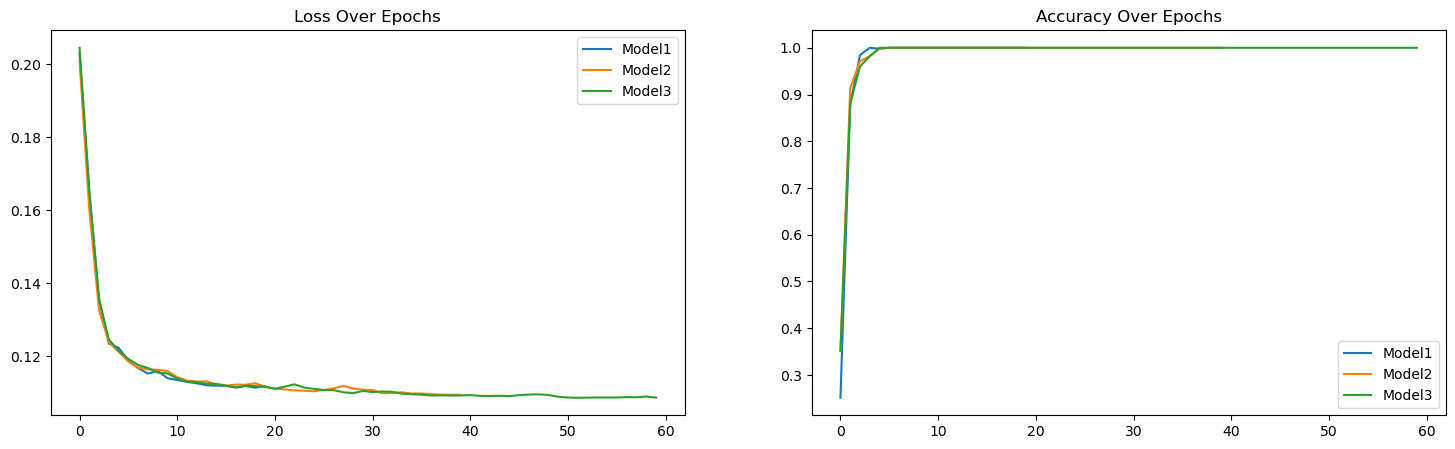

Final loss of Model1: 0.1118
Final loss of Model2: 0.1094
Final loss of Model3: 0.1086
Final accuracy of Model1: 90.826%
Final accuracy of Model2: 100.000%
Final accuracy of Model3: 100.000%


In [50]:
def test_model(epochs):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128))
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=epochs, batch_size=32)
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(y_test, y_pred)
    confusion_matrix(y_test, mapped_predictions)
    accuracy = custom_accuracy(y_test, mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(20)
Model2_history, Model2_accuracy = test_model(40)
Model3_history, Model3_accuracy = test_model(60)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')

plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')

plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()
print("Final loss of Model1:", f"{Model1_history.history['loss'][-1]:.4f}")
print("Final loss of Model2:", f"{Model2_history.history['loss'][-1]:.4f}")
print("Final loss of Model3:", f"{Model3_history.history['loss'][-1]:.4f}")
print("Final accuracy of Model1:", f"{Model1_accuracy:.3f}%")
print("Final accuracy of Model2:", f"{Model2_accuracy:.3f}%")
print("Final accuracy of Model3:", f"{Model3_accuracy:.3f}%")